# Import Necessary Libraries

In [7]:

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Load and Preprocess the Data

In [14]:
# Defining the image dimensions and batch size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Defining the directory path
data_dir = '/content/drive/MyDrive/SCOLIOSIS MODEL/ImagesOriginalSize'

# Function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    for label in ['scoliosis', 'normal']:  # here have two classes
        class_dir = os.path.join(data_dir, label)
        class_label = 0 if label == 'normal' else 1

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(img)
            labels.append(class_label)

    return np.array(images), np.array(labels)

# Load images and labels
X, y = load_data(data_dir)

# Normalize pixel values between 0 and 1
X = X / 255.0

# Reshape images to add a channel dimension (required for CNN)
X = X.reshape(X.shape[0], IMG_HEIGHT, IMG_WIDTH, 1)

# Convert labels to categorical format
y = to_categorical(y, num_classes=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Data Augmentation

In [15]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


# Build the CNN Model

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for 2 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,322 (12.60 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [17]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(X_test, y_test),
                    epochs=30,
                    callbacks=[early_stopping])


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6696 - loss: 0.7313 - val_accuracy: 0.7885 - val_loss: 0.5044
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 985ms/step - accuracy: 0.7213 - loss: 0.5758 - val_accuracy: 0.7885 - val_loss: 0.4665
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7370 - loss: 0.4898 - val_accuracy: 0.7885 - val_loss: 0.5307
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 994ms/step - accuracy: 0.7203 - loss: 0.4608 - val_accuracy: 0.7885 - val_loss: 0.5390
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 993ms/step - accuracy: 0.6826 - loss: 0.5129 - val_accuracy: 0.7885 - val_loss: 0.4864
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6977 - loss: 0.4656 - val_accuracy: 0.7885 - val_loss: 0.4963
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 974ms/step - accuracy: 0.7081 - loss: 0.4125 - val_accuracy: 0.7500 - val_loss: 0.4723


# Evaluating the Model

In [18]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")


2/2 - 0s - 238ms/step - accuracy: 0.7885 - loss: 0.4665
Test Accuracy: 0.7885


# Visualize Training History

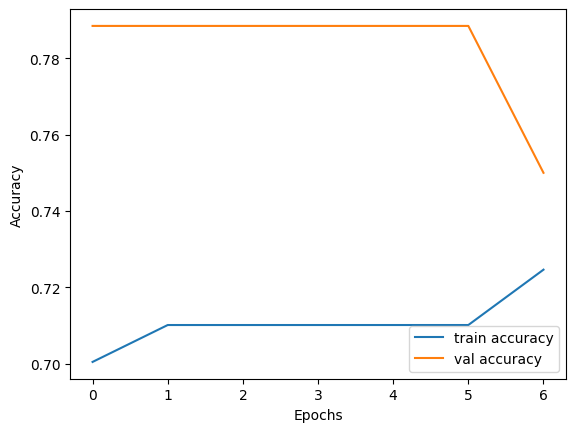

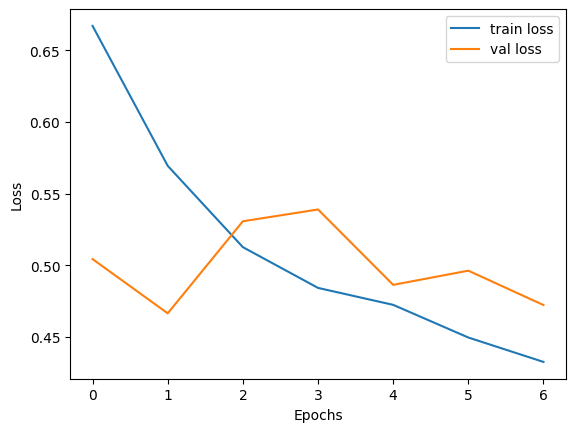

In [19]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Saving the Model

In [28]:
model.save('/content/drive/MyDrive/SCOLIOSIS MODEL/scoliosis_model.h5')


# Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 778ms/step


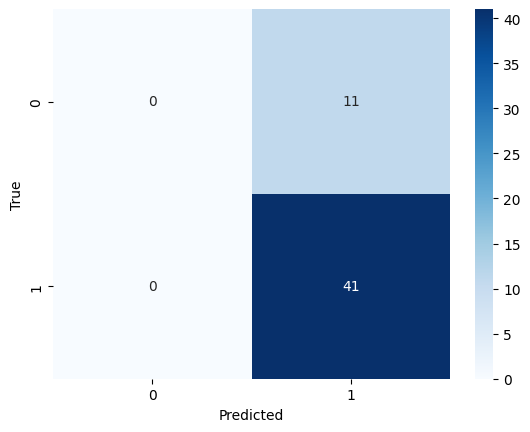

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Classification Report

In [22]:
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Scoliosis']))


              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        11
   Scoliosis       0.79      1.00      0.88        41

    accuracy                           0.79        52
   macro avg       0.39      0.50      0.44        52
weighted avg       0.62      0.79      0.70        52



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ROC-AUC Curve

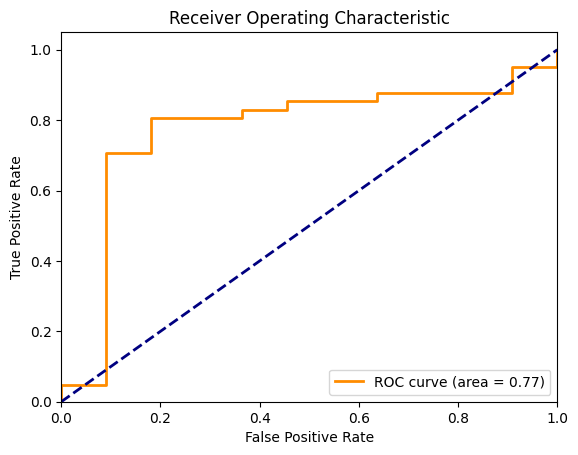

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Model Predictions

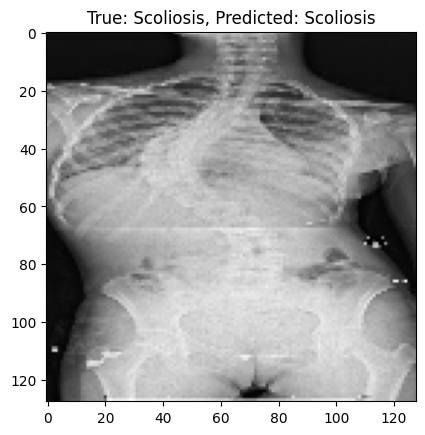

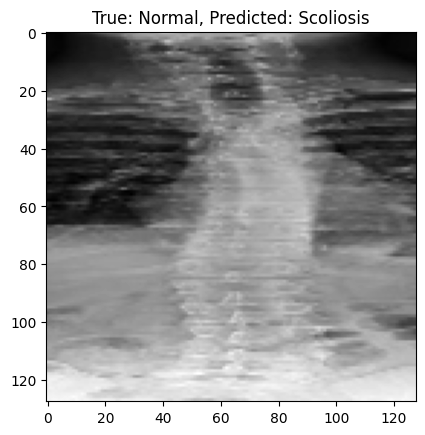

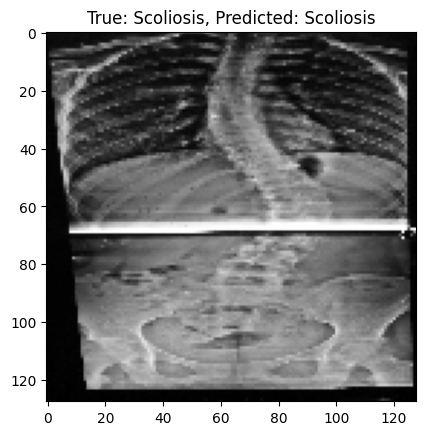

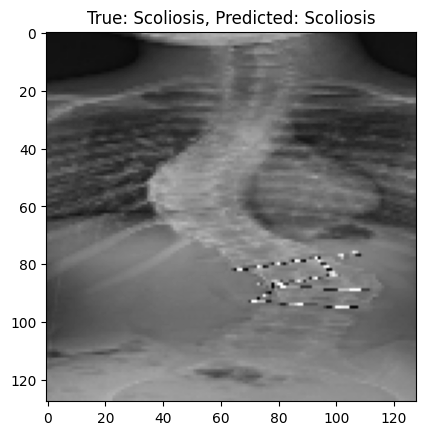

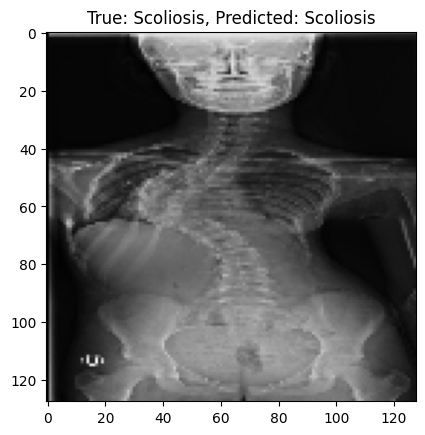

In [25]:
def plot_sample_images(X, y_true, y_pred_classes, n_samples=5):
    indices = np.random.choice(len(X), n_samples)
    for i in indices:
        plt.imshow(X[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.title(f"True: {['Normal', 'Scoliosis'][y_true[i]]}, Predicted: {['Normal', 'Scoliosis'][y_pred_classes[i]]}")
        plt.show()

plot_sample_images(X_test, y_true, y_pred_classes)


# Visualizing real world Predictions

In [29]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/SCOLIOSIS MODEL/scoliosis_model.h5')


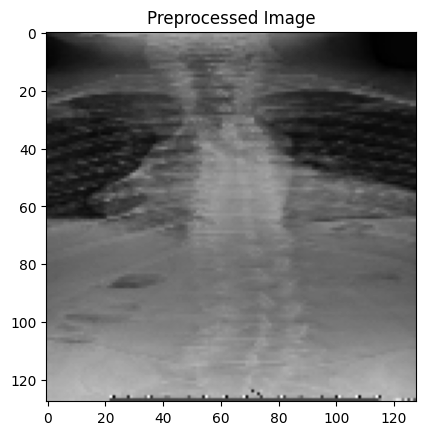

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(image_path, img_height, img_width):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    img = cv2.resize(img, (img_width, img_height))  # Resize image
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

# Load and preprocess the image
image_path = '/content/drive/MyDrive/SCOLIOSIS MODEL/test-img-draft/xkt857dsxk-1/ImagesOriginalSize/NormalFinal/N1,N,40,M_1_0.jpg'
img_height, img_width = 128, 128
processed_image = preprocess_image(image_path, img_height, img_width)

# Display the image
plt.imshow(processed_image.squeeze(), cmap='gray')
plt.title('Preprocessed Image')
plt.show()


In [40]:
# Predict the class
prediction = model.predict(processed_image)

# Get the class with the highest probability
predicted_class = np.argmax(prediction, axis=1)[0]

# Map the prediction to the corresponding class label
class_labels = ['Normal', 'Scoliosis']
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Class: Scoliosis


In [41]:
# Display the predicted probabilities
probability = prediction[0][predicted_class]
print(f"Predicted Probability: {probability:.2f}")


Predicted Probability: 0.69


In [43]:

image_paths = ['/content/drive/MyDrive/SCOLIOSIS MODEL/test/R (1).jpeg', '/content/drive/MyDrive/SCOLIOSIS MODEL/test/OIP (4).jpeg']
true_labels = [0, 1]  # 0 for Normal, 1 for Scoliosis

correct_predictions = 0
total_images = len(image_paths)

for i, img_path in enumerate(image_paths):
    img = preprocess_image(img_path, img_height, img_width)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]

    if predicted_class == true_labels[i]:
        correct_predictions += 1

# Calculate accuracy on real-world images
accuracy = correct_predictions / total_images
print(f"Accuracy on real-world images: {accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Accuracy on real-world images: 50.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


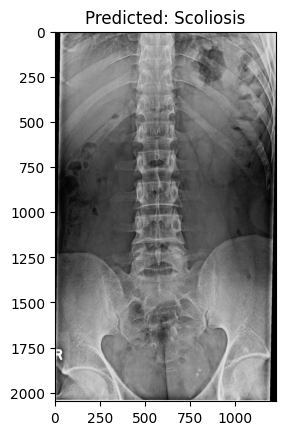

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


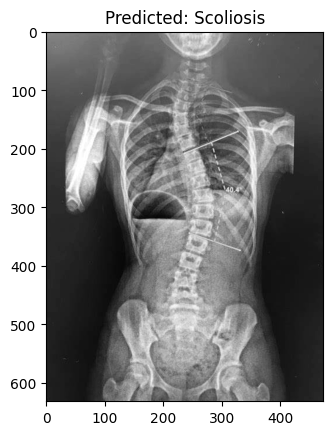

In [45]:
for i, img_path in enumerate(image_paths[:5]):
    img = preprocess_image(img_path, img_height, img_width)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    plt.figure()
    img_to_show = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_to_show, cmap='gray')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()


# VIA Manual Annotation

In [1]:
!wget https://www.robots.ox.ac.uk/~vgg/software/via/via-2.0.10.html -O via.html

--2024-09-12 09:01:38--  https://www.robots.ox.ac.uk/~vgg/software/via/via-2.0.10.html
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘via.html’

via.html                [  <=>               ] 411.65K   912KB/s    in 0.5s    

2024-09-12 09:01:39 (912 KB/s) - ‘via.html’ saved [421527]



In [2]:
from google.colab import files
files.download('via.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Cobb Angle Calculation

In [3]:
import pandas as pd
import numpy as np
import json


In [8]:
# Load the annotation file (CSV example)
annotation_path = '/content/drive/MyDrive/SCOLIOSIS MODEL/test/3_csv.csv'
annotations = pd.read_csv(annotation_path)

# Function to extract 'cx' and 'cy' from the 'region_shape_attributes' column
def extract_coordinates(row):
    data = json.loads(row)  # Convert the string to a dictionary
    return pd.Series([data.get('cx', None), data.get('cy', None)])  # Extract 'cx' and 'cy'

# Apply the function to the 'region_shape_attributes' column to create 'cx' and 'cy' columns
annotations[['cx', 'cy']] = annotations['region_shape_attributes'].apply(extract_coordinates)
# Display the updated dataframe
print(annotations)

                    filename  file_size file_attributes  region_count  \
N10  Rt TAIS  M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   

                 region_id              region_shape_attributes  \
N10  Rt TAIS  M          0   {"name":"point","cx":318,"cy":981}   
              M          1   {"name":"point","cx":465,"cy":976}   
              M          2  {"name":"point","cx":321,"cy":1068}   
              M          3  {"name":"point","cx":473,"cy":1073}   
       

In [9]:

# Extract upper and lower endplate points
# Assuming the first 4 points are for Cobb angle calculation
upper_point_1 = (annotations.iloc[0]['cx'], annotations.iloc[0]['cy'])  # First point of upper vertebra
upper_point_2 = (annotations.iloc[1]['cx'], annotations.iloc[1]['cy'])  # Second point of upper vertebra
lower_point_1 = (annotations.iloc[2]['cx'], annotations.iloc[2]['cy'])  # First point of lower vertebra
lower_point_2 = (annotations.iloc[3]['cx'], annotations.iloc[3]['cy'])  # Second point of lower vertebra

# Cobb Angle Calculation function
def calculate_cobb_angle(upper_line, lower_line):
    def line_slope(line):
        x1, y1, x2, y2 = line
        return (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')

    # Get the slopes of the two lines
    slope1 = line_slope(upper_line)
    slope2 = line_slope(lower_line)

    # Calculate the angle in radians between the two lines
    if slope1 == float('inf') or slope2 == float('inf'):
        angle_radians = np.pi / 2  # 90 degrees if one line is vertical
    else:
        angle_radians = np.arctan(abs((slope2 - slope1) / (1 + slope2 * slope1)))

    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

# Define the lines using the points
upper_line = [upper_point_1[0], upper_point_1[1], upper_point_2[0], upper_point_2[1]]
lower_line = [lower_point_1[0], lower_point_1[1], lower_point_2[0], lower_point_2[1]]

# Calculate the Cobb angle
cobb_angle = calculate_cobb_angle(upper_line, lower_line)
print(f'Cobb Angle: {cobb_angle:.2f} degrees')


Cobb Angle: 3.83 degrees
